## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [29]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
import joblib
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [30]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    
convert_mic('>64')

0

In [31]:
# Load meta data
meta_data = pd.read_excel('data/Cumulative_Peptide_data_PG1.xlsx', index_col=0)
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


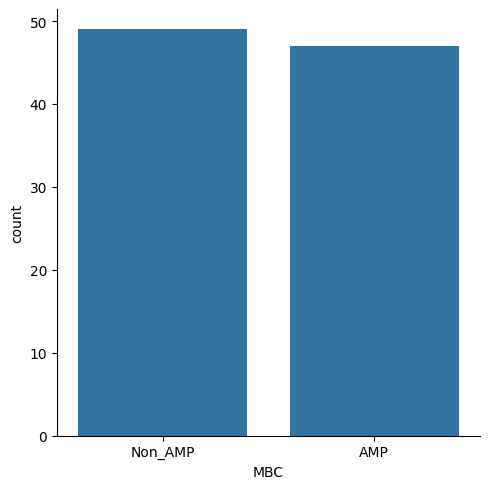

In [32]:
# Create the new target selectivity
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Load embedding

In [33]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,MBC,%Hemolysis,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [34]:
 # define target to evaluete the model
target = data["MBC"]

In [35]:
# define target
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


In [36]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (76, 5120), Test set shape: (20, 5120)


## Run models

In [ ]:

pcas = [10, 15, 20, 25, 30, 35, 40]

results_final = pd.DataFrame()
results_cv_final = pd.DataFrame()

for num_pca in pcas:
    # instantiate PCA
    pca = PCA(num_pca)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # store the results
    results = pd.DataFrame()
    results_cv = pd.DataFrame()

    # create a list of classifiers to test
    classifiers = [
        LogisticRegression(),
        GaussianNB(),
        SVC(),
        RandomForestClassifier()
    ]

    # create a dictionary of hyperparameters to search over for each classifier
    param_grids = [
        {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False], 'solver': ['liblinear', 'saga'],'max_iter': [10000]},
        {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,]},
        {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
        {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'max_features': ['sqrt', 'log2']}
    ]

    # create a list of names for the classifiers for printing results
    model_names = ["LogisticRegression", 'GaussianNB', "SVM", 'RandomForest']


    # loop over the classifiers and hyperparameter grids
    for name, clf, param_grid in zip(model_names, classifiers, param_grids):

        # create a GridSearchCV object with 5-fold cross-validation
        grid_search = GridSearchCV(clf, param_grid, cv=25, n_jobs=25)

        # fit the grid search object to the training data
        grid_search.fit(X_train_pca, y_train)

        # k-fold cross-validation on the training set
        accuracy_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='accuracy', n_jobs=25)
        recall_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='recall', n_jobs=25)
        precision_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='precision', n_jobs=25)
        f1_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='f1', n_jobs=25)


        # make predictions on the test data using the best model found by the grid search
        train_y_pred = grid_search.best_estimator_.predict(X_train_pca)
        test_y_pred = grid_search.best_estimator_.predict(X_test_pca)

        # evaluate the performance of the best model on the train data using accuracy score
        train_accuracy = metrics.accuracy_score(y_train, train_y_pred)
        train_recall = metrics.recall_score(y_train, train_y_pred)
        train_precision = metrics.precision_score(y_train, train_y_pred, zero_division=0)
        train_f1_score = metrics.f1_score(y_train, train_y_pred)

        # evaluate the performance of the best model on the test data using accuracy score
        test_accuracy = metrics.accuracy_score(y_test, test_y_pred)
        test_recall = metrics.recall_score(y_test, test_y_pred)
        test_precision = metrics.precision_score(y_test, test_y_pred, zero_division=0)
        test_f1_score = metrics.f1_score(y_test, test_y_pred)

        print(name)
        print(f'NUm PCA {num_pca}, Train Accuracy: {train_accuracy.round(2)}, Train Recall: {train_recall.round(2)}, Train Precision: {train_precision.round(2)}')
        print(f'NUm PCA {num_pca}, Test Accuracy: {test_accuracy.round(2)}, Test Recall: {test_recall.round(2)}, Test Precision: {test_precision.round(2)}')
        print()

        # Saving results
        res_dict = {}
        res_dict["embedding"] = 'esm2_15B'
        res_dict["embed_size"] = features.shape[1]
        res_dict["model"] = name
        res_dict["NUm_pca"] = num_pca

        res_dict["Train_Accuracy"] = train_accuracy.round(2)
        res_dict["Train_recall"] = train_recall.round(2)
        res_dict["Train_precision"] = train_precision.round(2)
        res_dict["Train_f1"] = train_f1_score.round(2)

        res_dict["Test_Accuracy"] = test_accuracy.round(2)
        res_dict["Test_recall"] = test_recall.round(2)
        res_dict["Test_precision"] = test_precision.round(2)
        res_dict["Test_f1"] = test_f1_score.round(2)
        res_dict['best_params'] = str(grid_search.best_params_)
        # updating data frame with results
        results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)
    

        # save results from cross-validation
        res_cv_dict = {
            "model": [name for i in range(len(accuracy_cv_scores))],
            "Num_pca": [num_pca for i in range(len(accuracy_cv_scores))],
            "Accuracy_CV_scores": accuracy_cv_scores,
            "Recall_CV_scores": recall_cv_scores,
            "Precision_CV_scores": precision_cv_scores,
            "F1_CV_scores": f1_cv_scores,
        }
        # updating data frame with results
        results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

    results_final = pd.concat([results_final, results]).reset_index(drop=True)
    results_cv_final = pd.concat([results_cv_final, results_cv]).reset_index(drop=True)

results_final.to_excel('results/results_classification_activity_v02.xlsx')
results_cv_final.to_excel('results/results_cv_classification_activity_v02.xlsx')

## Results Visualization

In [6]:
results_cv = pd.read_excel('results/results_cv_classification_activity_v02.xlsx', index_col=0)
results_cv.groupby(['model', 'Num_pca']).mean()

Accuracy_CV_scores  Recall_CV_scores  \
model              Num_pca                                         
GaussianNB         10                 0.643333              0.66   
                   15                 0.656667              0.62   
                   20                 0.593333              0.60   
                   25                 0.590000              0.54   
                   30                 0.583333              0.58   
                   35                 0.606667              0.62   
                   40                 0.606667              0.58   
LogisticRegression 10                 0.576667              0.66   
                   15                 0.603333              0.74   
                   20                 0.590000              0.66   
                   25                 0.563333              0.68   
                   30                 0.590000              0.70   
                   35                 0.563333              0.60   
                   40                 0.563333              0.60   
RandomForest       10                 0.523333              0.52   
                   15                 0.563333              0.50   
                   20                 0.643333              0.54   
                   25                 0.576667              0.54   
                   30                 0.683333              0.50   
                   35                 0.546667              0.56   
                   40                 0.580000              0.54   
SVM                10                 0.643333              0.68   
                   15                 0.510000              0.62   
                   20                 0.523333              0.58   
                   25                 0.576667              0.58   
                   30                 0.470000              0.40   
                   35                 0.523333              0.44   
                   40                 0.603333              0.48   

                            Precision_CV_scores  F1_CV_scores  
model              Num_pca                                     
GaussianNB         10                  0.573333      0.580000  
                   15                  0.540000      0.545333  
                   20                  0.493333      0.505333  
                   25                  0.493333      0.470667  
                   30                  0.506667      0.501333  
                   35                  0.540000      0.544000  
                   40                  0.466667      0.489333  
LogisticRegression 10                  0.593333      0.577333  
                   15                  0.566667      0.604000  
                   20                  0.573333      0.577333  
                   25                  0.546667      0.564000  
                   30                  0.580000      0.602667  
                   35                  0.546667      0.538667  
                   40                  0.493333      0.510667  
RandomForest       10                  0.526667      0.360000  
                   15                  0.553333      0.466667  
                   20                  0.566667      0.526667  
                   25                  0.493333      0.477333  
                   30                  0.446667      0.478667  
                   35                  0.453333      0.405333  
                   40                  0.493333      0.413333  
SVM                10                  0.620000      0.605333  
                   15                  0.486667      0.510667  
                   20                  0.500000      0.492000  
                   25                  0.493333      0.497333  
                   30                  0.360000      0.333333  
                   35                  0.426667      0.393333  
                   40                  0.500000      0.452000

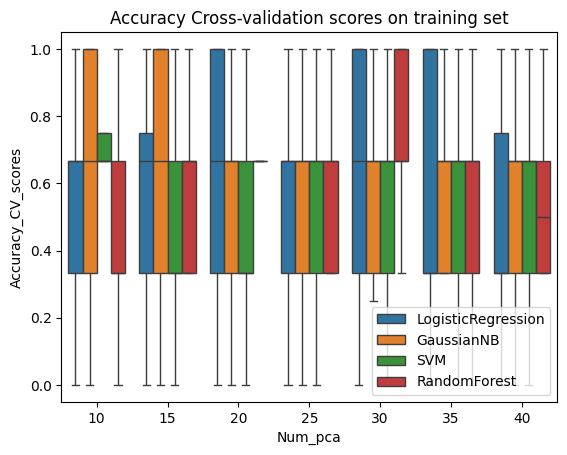

In [13]:
sns.boxplot(data=results_cv, x='Num_pca', y='Accuracy_CV_scores', hue='model', showfliers=False)
plt.title('Accuracy Cross-validation scores on training set')
plt.legend(loc='lower right')
plt.show()

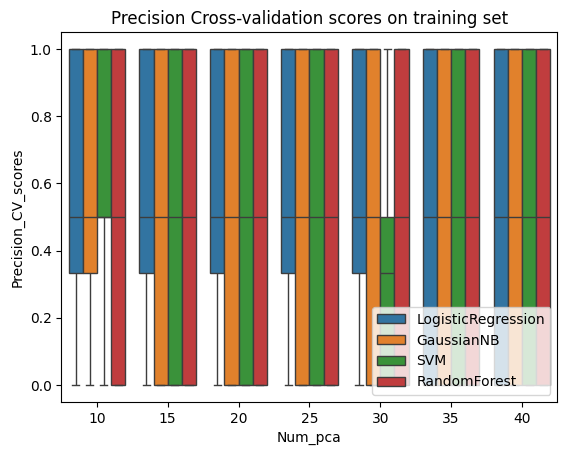

In [16]:
sns.boxplot(data=results_cv, x='Num_pca', y='Precision_CV_scores', hue='model', showfliers=False)
plt.title('Precision Cross-validation scores on training set')
plt.legend(loc='lower right')
plt.show()

## Train x Test

In [20]:
results_final = pd.read_excel('results/results_classification_activity_v02.xlsx', index_col=0)
results_final

,embedding,embed_size,model,NUm_pca,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
0,esm2_15B,5120,LogisticRegression,10,0.70,0.83,0.64,0.72,0.90,1.00,0.85,0.92,"{'C': 10, 'fit_intercept': False, 'max_iter': ..."
1,esm2_15B,5120,GaussianNB,10,0.75,0.75,0.73,0.74,0.85,1.00,0.79,0.88,{'var_smoothing': 1e-09}
2,esm2_15B,5120,SVM,10,0.91,1.00,0.84,0.91,0.80,1.00,0.73,0.85,"{'C': 10, 'class_weight': 'balanced', 'gamma':..."
3,esm2_15B,5120,RandomForest,10,0.99,1.00,0.97,0.99,0.80,0.82,0.82,0.82,"{'max_depth': 30, 'max_features': 'log2', 'min..."
4,esm2_15B,5120,LogisticRegression,15,0.75,0.89,0.68,0.77,0.90,1.00,0.85,0.92,"{'C': 10, 'fit_intercept': False, 'max_iter': ..."
5,esm2_15B,5120,GaussianNB,15,0.78,0.83,0.73,0.78,0.85,1.00,0.79,0.88,{'var_smoothing': 0.001}
6,esm2_15B,5120,SVM,15,0.93,1.00,0.88,0.94,0.85,1.00,0.79,0.88,"{'C': 10, 'class_weight': None, 'gamma': 'auto..."
7,esm2_15B,5120,RandomForest,15,0.99,1.00,0.97,0.99,0.85,0.91,0.83,0.87,"{'max_depth': 10, 'max_features': 'log2', 'min..."
8,esm2_15B,5120,LogisticRegression,20,0.74,0.81,0.69,0.74,0.85,0.91,0.83,0.87,"{'C': 0.1, 'fit_intercept': False, 'max_iter':..."
9,esm2_15B,5120,GaussianNB,20,0.79,0.86,0.74,0.79,0.75,0.91,0.71,0.80,{'var_smoothing': 1e-09}


In [23]:
# Reshape the dataframe to long format
melted_df = pd.melt(results_final, 
                    id_vars=['NUm_pca', 'model'], 
                    value_vars=['Test_Accuracy', 'Train_Accuracy'], 
                    var_name='Score Type', value_name='Accuracy')

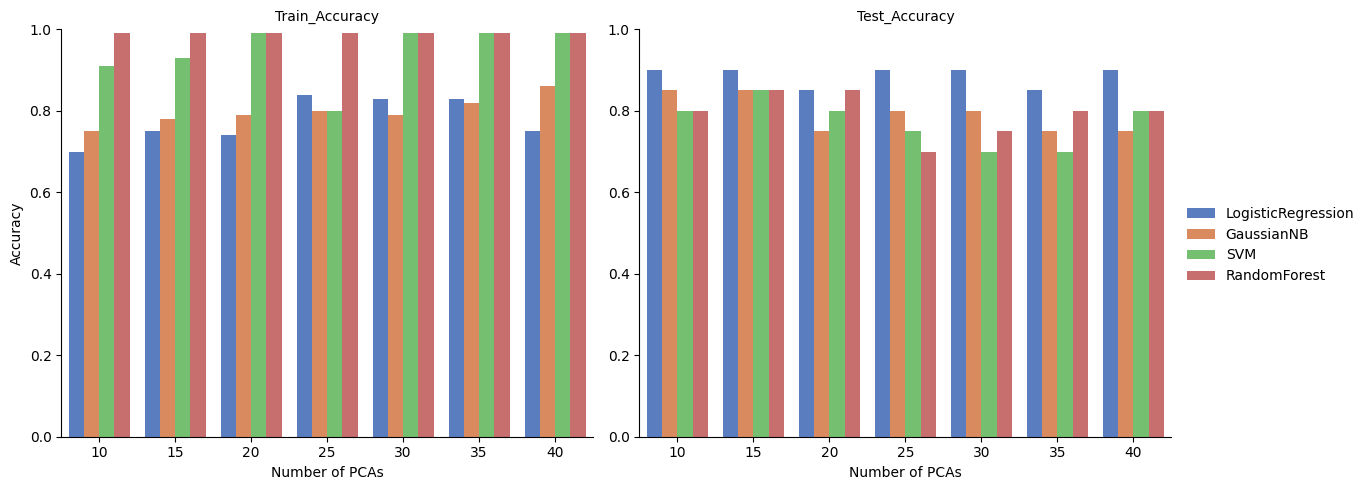

In [27]:
# Example using FacetGrid for a categorical breakdown
g = sns.FacetGrid(melted_df, col="Score Type", sharey=False, height=5, aspect=1.2, ylim=(0,1), col_order=['Train_Accuracy', 'Test_Accuracy'])
g.map_dataframe(sns.barplot, x="NUm_pca", y="Accuracy", hue='model', palette='muted')
g.set_axis_labels("Number of PCAs", "Accuracy")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
plt.show()

To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.   
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.   
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

## Fine Tunning Model with best hyperparameter found with Gridsearch

In [39]:
results_final.query('NUm_pca == 30')

,embedding,embed_size,model,NUm_pca,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
16,esm2_15B,5120,LogisticRegression,30,0.83,0.81,0.83,0.82,0.90,1.00,0.85,0.92,"{'C': 1, 'fit_intercept': True, 'max_iter': 10..."
17,esm2_15B,5120,GaussianNB,30,0.79,0.89,0.73,0.80,0.80,1.00,0.73,0.85,{'var_smoothing': 0.001}
18,esm2_15B,5120,SVM,30,0.99,0.97,1.00,0.99,0.70,0.55,0.86,0.67,"{'C': 1, 'class_weight': None, 'gamma': 1, 'ke..."
19,esm2_15B,5120,RandomForest,30,0.99,0.97,1.00,0.99,0.75,0.73,0.80,0.76,"{'max_depth': None, 'max_features': 'log2', 'm..."


In [54]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (76, 5120), Test set shape: (20, 5120)


In [55]:
num_pca_components = 30

pca = PCA(num_pca_components)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Logistic Regression

In [56]:
results_final.iloc[16, 12]

"{'C': 1, 'fit_intercept': True, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}"

In [57]:
logR= LogisticRegression(penalty='l2',
                        C=1,
                        fit_intercept=True,
                        solver='liblinear',
                        max_iter=10000)
         

# fit the model
logR.fit(X_train_pca, y_train)

# print Accuracy score
print(f'Train R2 score: {logR.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {logR.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.83
Test R2 score: 0.90


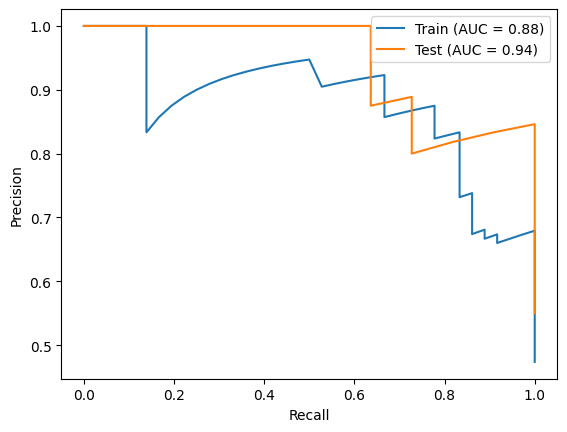

In [58]:
# Predict probabilities on the training and testing sets
y_train_proba = logR.predict_proba(X_train_pca)[:, 1]
y_test_proba = logR.predict_proba(X_test_pca)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

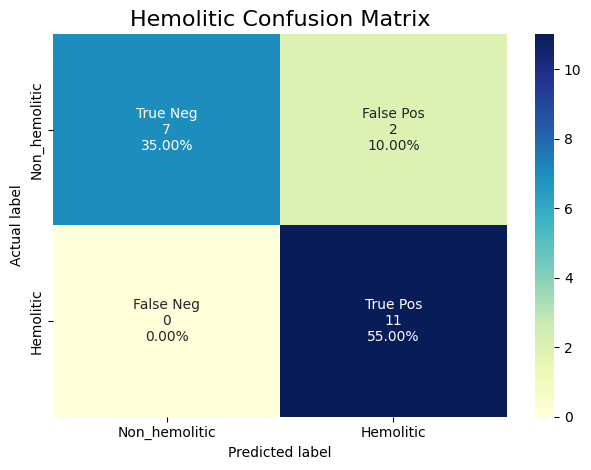

In [59]:
#confusion_matrix, 
y_pred = logR.predict(X_test_pca)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_hemolitic', 'Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolitic Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [60]:
## save the model
joblib.dump(logR, 'models/model_v02_logR30_esm2_15B_activity_classification.pkl')

['models/model_logR30_esm2_15B_activity_regression_v02.pkl']

## Gaussian NB

In [61]:
results_final.iloc[17, 12]

"{'var_smoothing': 0.001}"

In [62]:
gnb = GaussianNB(
    var_smoothing= 0.001,
    )

gnb.fit(X_train_pca, y_train)

# print Accuracy score
print(f'Train R2 score: {gnb.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {gnb.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.79
Test R2 score: 0.80


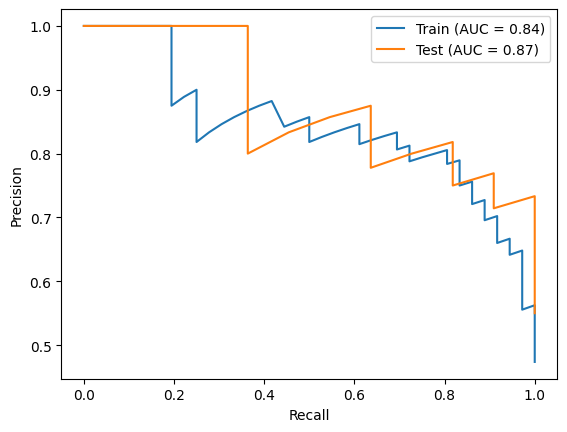

In [63]:
# Predict probabilities on the training and testing sets
y_train_proba = gnb.predict_proba(X_train_pca)[:, 1]
y_test_proba = gnb.predict_proba(X_test_pca)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

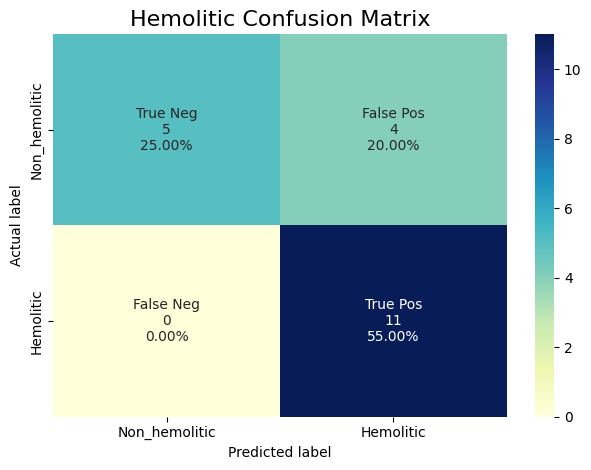

In [64]:
#confusion_matrix, 
y_pred = gnb.predict(X_test_pca)
conf_m = metrics.confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_hemolitic', 'Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolitic Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [65]:
## save the model
joblib.dump(gnb, 'models/model_v02_GNV30_esm2_15B_activity_classification.pkl')

['models/model_GNV30_esm2_15B_activity_regression_v02.pkl']

# Save the model

GNB and logR has less change to be overfitting